<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Code-Along

_Authors: Joseph Nelson (DC)_

---

### Learning Objectives
- Conduct a Dickey-Fuller test for stationarity and plot the results.
- Perform first and second order differencing, as well as seasonal differencing on data.
- Plot ACF and PACF with European retail data.
- Examine the use of SARIMAX state-space modeling for advanced time series forecasting.

### Lesson Guide
- [Statsmodels' Time Series Tools](#statsmodels-timeseries-tools)
- [Bus Ridership Data](#bus-ridership-data)
	- [Clean the Data](#clean-the-data)
	- [Create a Date Index for the Data](#create-a-date-index-for-the-data)
- [Plot the Riders Across Months](#plot-the-riders-across-months)
- [Decompose the Time Series and Plot](#decompose-the-timeseries-and-plot)
- [Dickey-Fuller Test of Stationarity](#dickey-fuller-test-of-stationarity)
	- [Perform a Test on the First-Differenced Time Series](#perform-test-on-the-first-differenced-timeseries)
	- [Perform a Test on *Seasonal*-Differenced Time Series](#perform-test-on-seasonal-differenced-timeseries)
	- [Perform a Test on the First Seasonal-Differenced Time Series](#perform-a-test-on-the-first-seasonal-differenced-timeseries)
- [Load the European Retail Data](#load-the-european-retail-data)
- [Create Autocorrelation and Partial Autocorrelation Plots](#create-autocorrelation-and-partial-autocorrelation-plots)
	- [Take a Second-Order Difference of the Retail Time Series](#take-a-second-order-difference-of-the-retail-timeseries)
- [Seasonal ARIMA With Additional Predictors (SARIMAX)](#seasonal-arima-with-additional-predictors-sarimax)
	- [Forecast Using the SARIMAX Model](#forecast-using-the-sarimax-model)
- [Additional Resources](#additional-resources)

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import seaborn as sns

<a id="statsmodels-timeseries-tools"></a>
## Statsmodels' Time Series Tools
---

Statsmodels, offers a wide variety of reliable time series analysis tools. We will start off by loading the autocorrelation and partial autocorrelation functions, as well as a function for decomposing time series.

In [6]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

<a id="bus-ridership-data"></a>
## Bus Ridership Data
---

We are going to play around with some Portland, Oregon, bus data. Load in the bus data below and check it out.

<a id="clean-the-data"></a>
### Clean the Data

In [7]:
# Data: https://datamarket.com/data/set/22w6/portland-oregon-average-monthly-bus-ridership-100-january-1973-through-june-1982-n114#!ds=22w6&display=line
bus = pd.read_csv('../datasets/portland-oregon-average-monthly-.csv')
bus.head()

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [8]:
bus.tail()

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
111,1969-04,1432
112,1969-05,1394
113,1969-06,1327
114,NaN,NaN
115,Portland Oregon average monthly bus ridership ...,n=114


There are a couple of bad rows. Get rid of them.

In [9]:
bus.drop([114,115], inplace=True)

Make the `riders` column an integer.

In [10]:
# Riders:
bus.columns= ['Date','riders']
bus['riders'] = bus.riders.astype(int)
bus.riders.head()

0    648
1    646
2    639
3    654
4    630
Name: riders, dtype: int64

<a id="create-a-date-index-for-the-data"></a>
### Create a Date Index for the Data

We are going to create an artificial date index using the `relativedelta()` function, as exemplified below. We will simply start at `1973-01-01` and iterate up a month at a time.

In [11]:
bus['Date'] = pd.to_datetime(bus['Date'])

In [12]:
dt = datetime(1973,1,1) - datetime(1960,1,1)
bus['Date'] = bus.Date + dt

In [13]:
bus.set_index('Date', inplace=True)

In [14]:
bus.head()

,riders
Date,
1973-01-01,648
1973-02-01,646
1973-03-02,639
1973-04-02,654
1973-05-02,630


In [11]:
bus.index

DatetimeIndex(['1973-01-01', '1973-02-01', '1973-03-02', '1973-04-02',
               '1973-05-02', '1973-06-02', '1973-07-02', '1973-08-02',
               '1973-09-02', '1973-10-02',
               ...
               '1981-09-02', '1981-10-02', '1981-11-02', '1981-12-02',
               '1982-01-02', '1982-02-02', '1982-03-02', '1982-04-02',
               '1982-05-02', '1982-06-02'],
              dtype='datetime64[ns]', name='Date', length=114, freq=None)

In [12]:
bus.index = pd.date_range('1/1/1973', 
                          periods=len(bus.index), freq='M')

In [13]:
bus.index

DatetimeIndex(['1973-01-31', '1973-02-28', '1973-03-31', '1973-04-30',
               '1973-05-31', '1973-06-30', '1973-07-31', '1973-08-31',
               '1973-09-30', '1973-10-31',
               ...
               '1981-09-30', '1981-10-31', '1981-11-30', '1981-12-31',
               '1982-01-31', '1982-02-28', '1982-03-31', '1982-04-30',
               '1982-05-31', '1982-06-30'],
              dtype='datetime64[ns]', length=114, freq='M')

<a id="plot-the-riders-across-months"></a>
## Plot the Riders Across Months
---

We can look at the raw ridership data first.

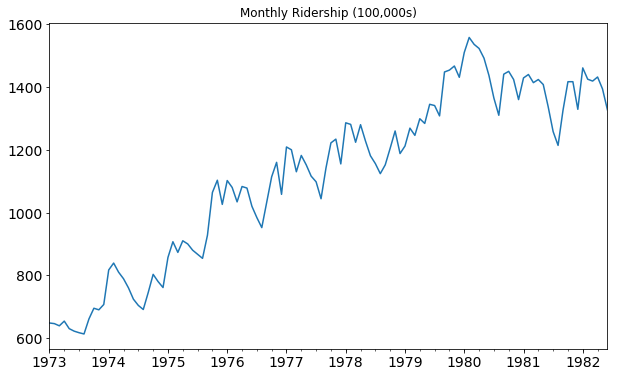

In [14]:
bus.riders.plot(figsize=(10,6), title= 'Monthly Ridership (100,000s)', fontsize=14)

<a id="decompose-the-timeseries-and-plot"></a>
## Decompose the Time Series and Plot
---

Using the `seasonal_decompose()` function, we can break the time series into its constituent parts.

Use the function on the `riders` data with a frequency of 12, then plot the data.

> **Hint:** The decomposition object from `seasonal_decompose()` has a `.plot()` function, like with Pandas DataFrames.

In [15]:
bus.dtypes

riders    int64
dtype: object

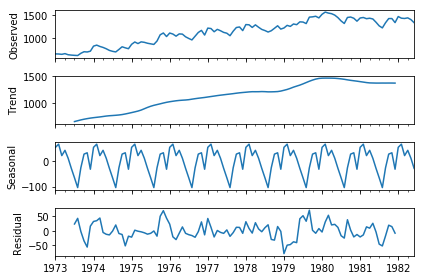

In [16]:
decomposition = seasonal_decompose(bus.riders, freq=12)  
decomposition.plot();

**Plot just the seasonal component.**

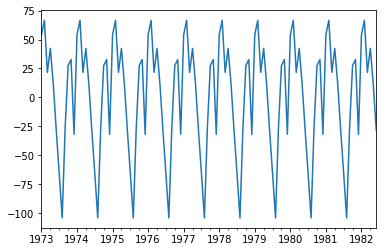

In [17]:
# Grab just one graphic doing the following:
seasonal = decomposition.seasonal 
seasonal.plot()

<a id="dickey-fuller-test-of-stationarity"></a>
## Dickey-Fuller Test of Stationarity
---

[We can perform an (augmented) Dickey-Fuller test of stationarity](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to evaluate whether or not the time series is stationary.


In [15]:
# Define a Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = timeseries.plot(color='blue',label='Original')
    mean = rolmean.plot(color='red', label='Rolling Mean')
    std = rolstd.plot(color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )


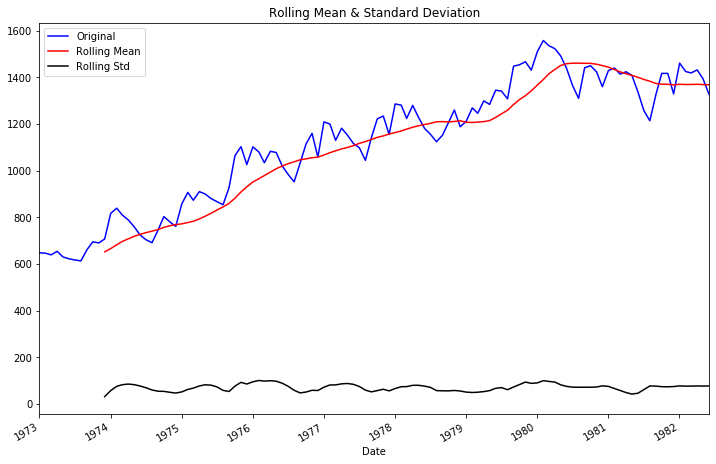

Results of Dickey-Fuller Test:
Test Statistic   -1.536597
p-value           0.515336
dtype: float64


In [16]:
# Perform the test.
test_stationarity(bus.riders)

<a id="perform-test-on-the-first-differenced-timeseries"></a>
### Perform a Test on the First-Differenced Time Series

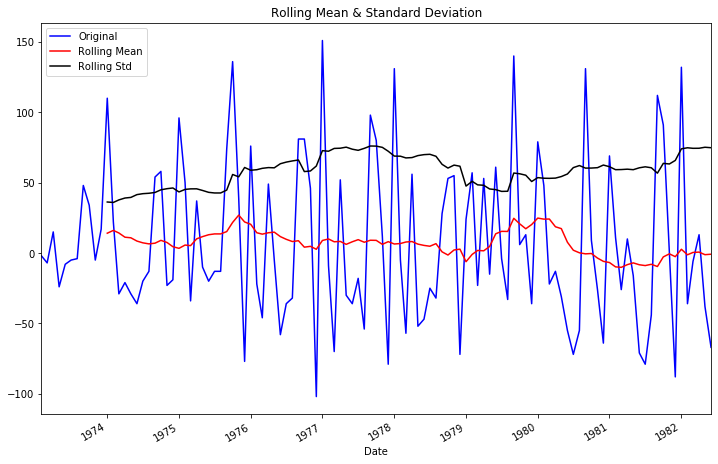

Results of Dickey-Fuller Test:
Test Statistic   -1.938696
p-value           0.314082
dtype: float64


In [17]:
# First difference:
bus['first_difference'] = bus.riders.diff()
test_stationarity(bus.first_difference.dropna())

<a id="perform-test-on-seasonal-differenced-timeseries"></a>
### Perform a Test on *Seasonal*-Differenced Time Series

Where the season will be a year's difference (12 months).

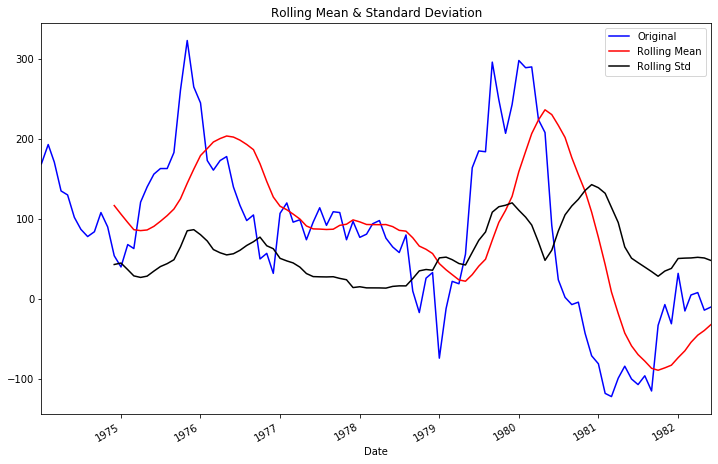

Results of Dickey-Fuller Test:
Test Statistic   -2.469741
p-value           0.123011
dtype: float64


In [18]:
# Seasonal difference:
bus['seasonal_difference'] = bus.riders.diff(12)  
test_stationarity(bus.seasonal_difference.dropna())

<a id="perform-a-test-on-the-first-seasonal-differenced-timeseries"></a>
### Perform a Test on the First Seasonal-Differenced Time Series

At this point, we can see that we have a significant result!

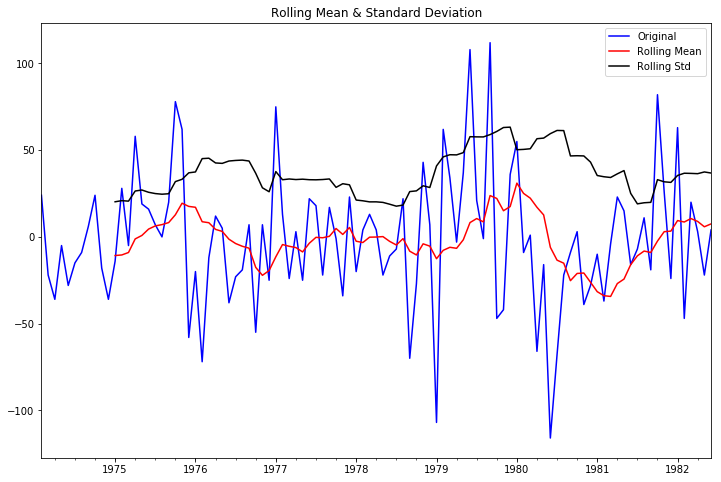

Results of Dickey-Fuller Test:
Test Statistic   -9.258520e+00
p-value           1.427874e-15
dtype: float64


In [113]:
# First seasonal difference:
bus['seasonal_first_difference'] = bus.first_difference.diff(12)  
test_stationarity(bus.seasonal_first_difference.dropna())

In [114]:
train_test = bus.dropna()

In [124]:
from statsmodels.tsa.arima_model import ARMA

train = train_test.head(80)
test = train_test.tail(21)

model = ARMA(train.seasonal_first_difference, (1,0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                 
=====================================================================================
Dep. Variable:     seasonal_first_difference   No. Observations:                   80
Model:                            ARMA(1, 0)   Log Likelihood                -408.659
Method:                              css-mle   S.D. of innovations             40.014
Date:                       Mon, 25 Jun 2018   AIC                            823.319
Time:                               14:21:17   BIC                            830.465
Sample:                           02-28-1974   HQIC                           826.184
                                - 09-30-1980                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -2.1704      5.015     -0.433      0.666     -12.000       7.659
ar.L1.seasonal_first_difference     0.1093      0.111      0.987      0.327      -0.108       0.326
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            9.1481           +0.0000j            9.1481            0.0000
-----------------------------------------------------------------------------
"""

In [125]:
len(test)

21

In [126]:
start = test.index[0].to_pydatetime()
end = test.index[-1].to_pydatetime()

#start = len(train) - 1
#end = start + len(test) - 1

predictions_oos = model.predict(start=start, end=end)
truth = test.seasonal_first_difference

In [127]:
model.forecast()

(array([-2.91697459]),
 array([40.01397284]),
 array([[-81.34292023,  75.50897105]]))

In [128]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(truth, predictions_oos))

23.88021525834234


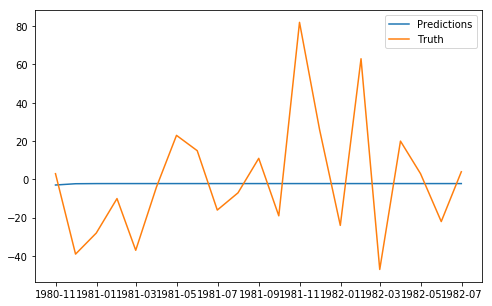

In [129]:
plt.subplots(figsize=(8,5))
plt.plot(truth.index, predictions_oos, label='Predictions')
plt.plot(truth.index, truth.values, label='Truth')
plt.legend()

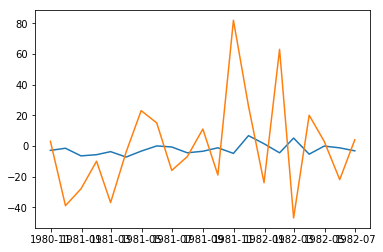

In [130]:
predictions_rolling = []
training_observations = list(train.seasonal_first_difference.values)
testing_observations = test.seasonal_first_difference.values

for obs in testing_observations:
    model_roll = ARMA(training_observations, (1,0)).fit(disp=0)
    predictions_rolling.append(model_roll.forecast()[0][0])
    training_observations.append(obs)
    
plt.plot(test.index, predictions_rolling, label='Fitted')
plt.plot(test.index, testing_observations, label='Truth')

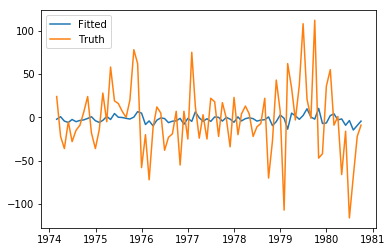

In [131]:
plt.plot(train.index, model.fittedvalues, label='Fitted')
plt.plot(train.index, train.seasonal_first_difference.values, label='Truth')
plt.legend()

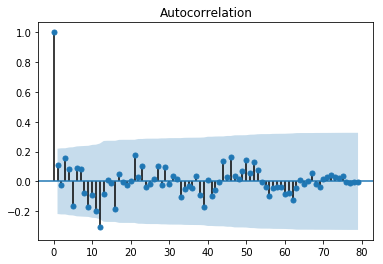

In [132]:
plot_acf(train.seasonal_first_difference.values);

<a id="load-the-european-retail-data"></a>
## Load the European Retail Data
---

Make the index the year and create an initial plot of the data.

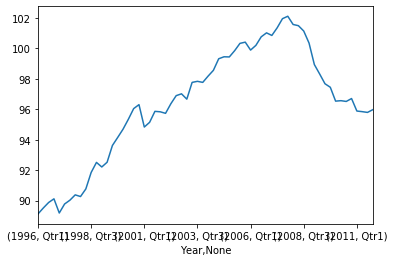

In [19]:
df = pd.read_csv('../datasets/euretail.csv')
df = df.set_index(['Year'])
df.head()
df.stack().plot()

In [20]:
df_stacked = df.stack()

In [21]:
idx = df.stack().index.levels
new_idx = []
for year in idx[0]:
    for qtr in idx[1]:
        new_idx.append(str(year)+'Q'+qtr[-1])

In [22]:
df_stacked.index = pd.to_datetime(pd.Series(new_idx)).dt.to_period('Q')

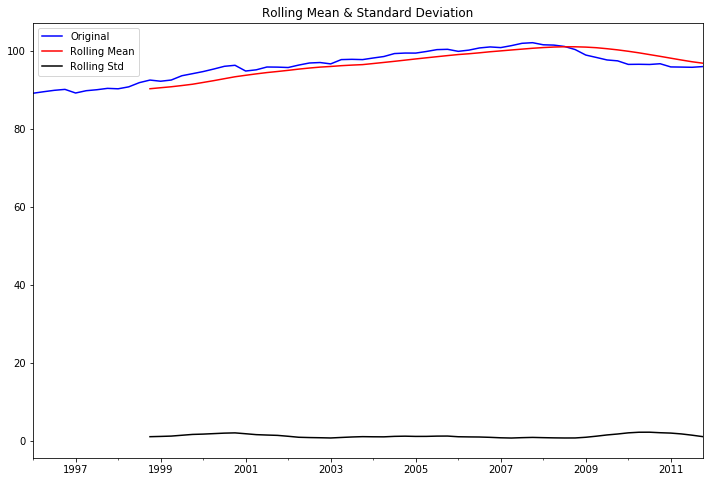

Results of Dickey-Fuller Test:
Test Statistic   -2.300304
p-value           0.171870
dtype: float64


In [23]:
test_stationarity(df_stacked)

<a id="create-autocorrelation-and-partial-autocorrelation-plots"></a>
## Create Autocorrelation and Partial Autocorrelation Plots 
---

Create a first-differenced time series of the retail data, then use `plot_acf` and `plot_pacf`.

In [137]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

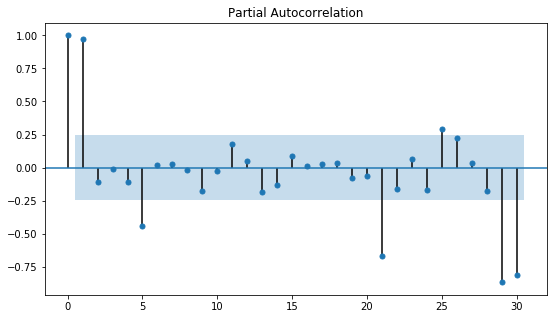

In [24]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(df_stacked, lags=30, ax=ax)
plt.show()  #multiples of 3,6,or 12 see if got any sig patterns

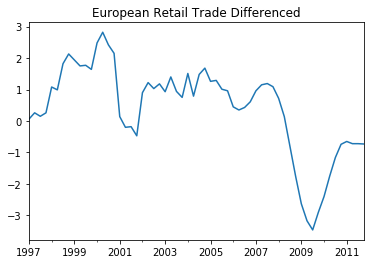

In [25]:
# Regular diff:
diff0 = df_stacked.diff(periods=4)[4:]
diff0.plot(title='European Retail Trade Differenced')

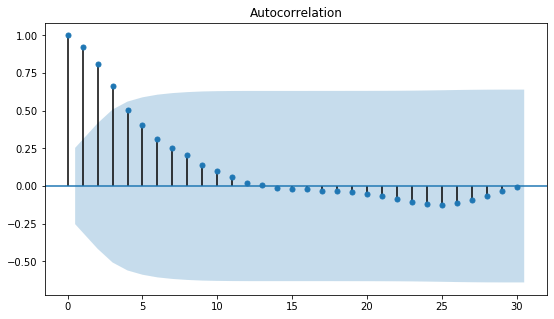

In [26]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(diff0, lags=30, ax=ax)
plt.show()

/Users/ikhyvicky/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


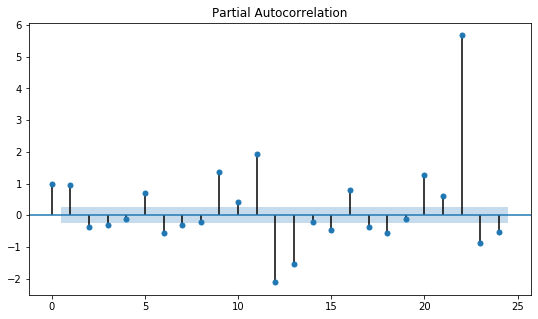

In [27]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(diff0, lags=24, ax=ax)
plt.show()

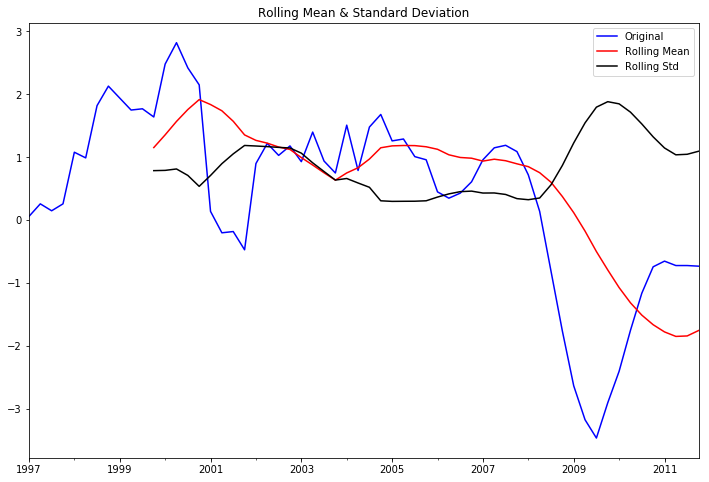

Results of Dickey-Fuller Test:
Test Statistic   -1.451746
p-value           0.557233
dtype: float64


In [158]:
test_stationarity(diff0)

<a id="take-a-second-order-difference-of-the-retail-timeseries"></a>
### Take a Second-Order Difference of the Retail Time Series

Plot the ACF and PACF again with the second-order differenced series.

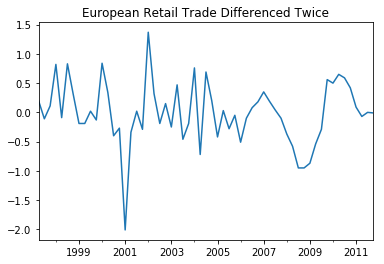

In [95]:
# Additional diff:
diff1 = diff0.diff()[1:]
diff1.plot(title='European Retail Trade Differenced Twice')


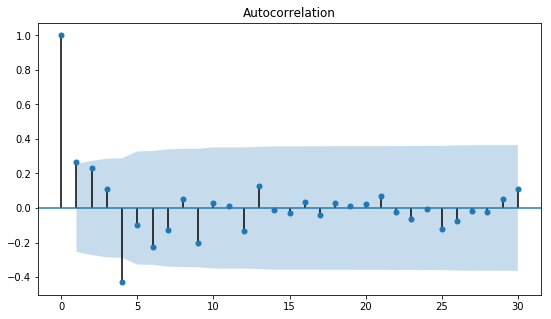

In [63]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(diff1, lags=30, ax=ax)
plt.show()

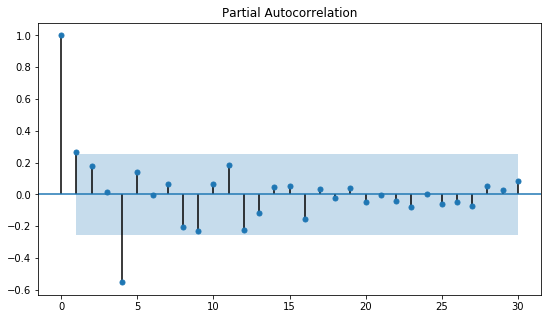

In [211]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(diff1, lags=30, ax=ax)
plt.show()

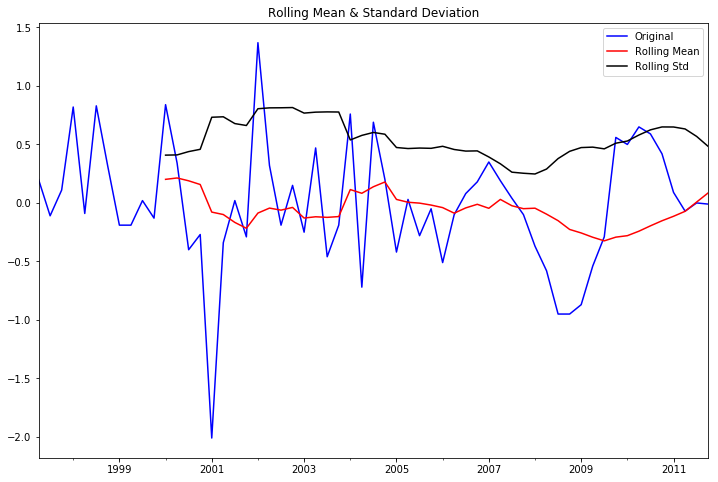

Results of Dickey-Fuller Test:
Test Statistic   -3.559370
p-value           0.006587
dtype: float64


In [160]:
test_stationarity(diff1)

<a id="seasonal-arima-with-additional-predictors-sarimax"></a>
## Seasonal ARIMA With Additional Predictors (SARIMAX)
---

The [SARIMAX model](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) is an advanced state-space model that allows us to build a seasonal ARIMA and also take into account the effects of other predictors.

The granular details of SARIMAX are beyond the scope of this walk-through, but we can build a model and use it to forecast as an example of Statsmodels' powerful time series analysis capabilities.

In [161]:
import statsmodels.api as sm

p = 0
d = 1
q = 1

P = 0
D = 1
Q = 1
s = 4

data = df.stack().values
model = sm.tsa.statespace.SARIMAX(data, order=(p,d,q), seasonal_order=(P,D,Q,s))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -34.680
Date:                           Mon, 25 Jun 2018   AIC                             75.360
Time:                                   14:30:08   BIC                             81.593
Sample:                                        0   HQIC                            77.793
                                            - 64                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2901      0.155      1.868      0.062      -0.014       0.594
ma.S.L4       -0.6909      0.132     -5.240

**Plot the residuals of the SARIMAX model.**

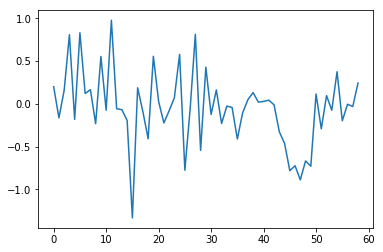

In [214]:
# Don't plot the first five values to account for data loss when differencing (d=1 + D=5).
residuals = results.resid[5:]
plt.plot(residuals)

**Plot the ACF and PACF of the residuals.**

What should we expect from the ACF and PACF of our residuals if the model is good?

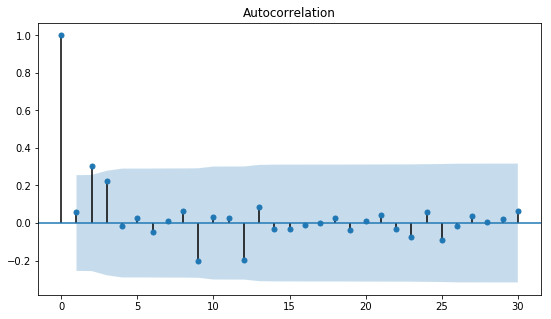

In [215]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(residuals, lags=30, ax=ax)
plt.show()

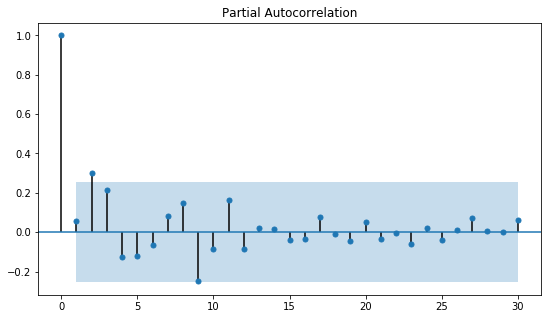

In [216]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(residuals, lags=30, ax=ax)
plt.show()

**Increase the order of the SARIMAX model.**

How do the results change?

In [167]:
model = sm.tsa.statespace.SARIMAX(data, order=(2,1,1), seasonal_order=(1,1,1,4))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 4)   Log Likelihood                 -29.917
Date:                           Mon, 25 Jun 2018   AIC                             71.833
Time:                                   14:32:26   BIC                             84.298
Sample:                                        0   HQIC                            76.699
                                            - 64                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6405      0.529      1.211      0.226      -0.396       1.677
ar.L2          0.1654      0.293      0.563

In [168]:
# AIC is slightly lower and therefore may be a better choice.

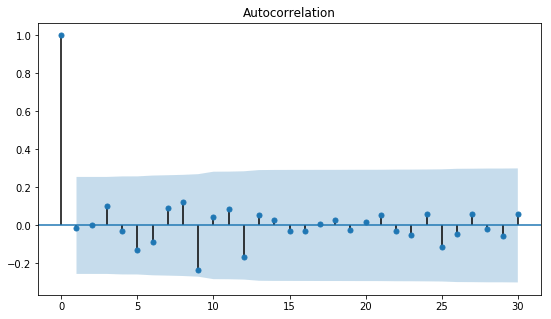

In [173]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(results.resid[5:], lags=30, ax=ax)
plt.show()

<a id="forecast-using-the-sarimax-model"></a>
### Forecast Using the SARIMAX Model

Statsmodels result objects from SARIMAX have a `.forecast()` function that can use the state-space model to predict out to future time points.

Forecast 12 additional time points and plot them.

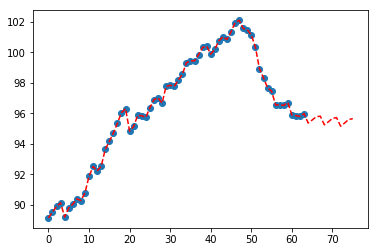

In [169]:
# Forecasting:
res = model.fit()
preds = res.forecast(12)
fcast = np.concatenate((data, preds), axis=0)

plt.figure();
plt.plot(data, 'o' , fcast, 'r--');

<a id='additional-resources'></a>
## Additional Resources
---

+ A Soft Introduction to [Akaike Information Criteria](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/)
+ A [Video Introduction](https://www.youtube.com/watch?v=YkD7ydzp9_E) to AIC
+ [Wikipedia's Entry on AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)
+ A Seasonal ARIMA [Code-Along](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) From Statsmodels
+ An excellent [Blog Code-Along](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/) to Seasonal ARIMA + [iPython Notebook](https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb)
+ Duke's Breakdown of [ACF and PACF](http://people.duke.edu/~rnau/411arim3.htm)
+ Duke's Breakdown of Available [Stationarity Transformations](http://people.duke.edu/~rnau/whatuse.htm)
+ A 35-Minute [Video Econometric](https://www.youtube.com/watch?v=Y2khrpVo6qI) Breakdown of ARIMA
+ [Wikipedia's Entry on Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
+ Stats Exchange's Breakdown of [Augmented Dickey-Fuller](http://stats.stackexchange.com/questions/44647/which-dickey-fuller-test-should-i-apply-to-a-time-series-with-an-underlying-mode)
+ Compliments of Jonathan: A Walk Through of Selecting PDQ from [Duke](http://people.duke.edu/~rnau/411arim.htm)
+ Compliments of Jonathan, Pt. 2: A Big Data Analytics With ARIMA [Case Study](http://sda-pakdd2014.weebly.com/uploads/2/4/0/8/24088081/7w12.pdf)
+ Bonus: Check Out [Granger Causality Tests](https://en.wikipedia.org/wiki/Granger_causality)
